In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


REAL = "Real"
FAKE = "Fake"

targets = {REAL: 0, FAKE: 1}

true_df = pd.read_csv("../datasets/True.csv")
fake_df = pd.read_csv("../datasets/Fake.csv")

print(true_df.shape)
print(fake_df.shape)

(21417, 4)
(23481, 4)


In [3]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Gathering the data

In [5]:
true_df["target"] = REAL
fake_df["target"] = FAKE

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head(10)

(44898, 5)


,title,text,subject,date,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",Fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",Fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",Fake
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",Real
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",Fake
5,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",Real
6,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",Real
7,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",Real
8,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",Fake
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",Fake


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


# Cleaning text

In [7]:
import re


def clean_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s!?]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()


df["text"] = df["text"].apply(clean_text)
df["title"] = df["title"].apply(clean_text)
df.head()

,title,text,subject,date,target
0,breaking gop chairman grassley has had enough ...,donald trump s white house is in chaos and the...,News,"July 21, 2017",Fake
1,failed gop candidates remembered in hilarious ...,now that donald trump is the presumptive gop n...,News,"May 7, 2016",Fake
2,mike pence s new dc neighbors are hilariously ...,mike pence is a huge homophobe he supports ex ...,News,"December 3, 2016",Fake
3,california ag pledges to defend birth control ...,san francisco reuters california attorney gene...,politicsNews,"October 6, 2017",Real
4,az ranchers living on us mexico border destroy...,twisted reasoning is all that comes from pelos...,politics,"Apr 25, 2017",Fake


# Amount of fake news and real news

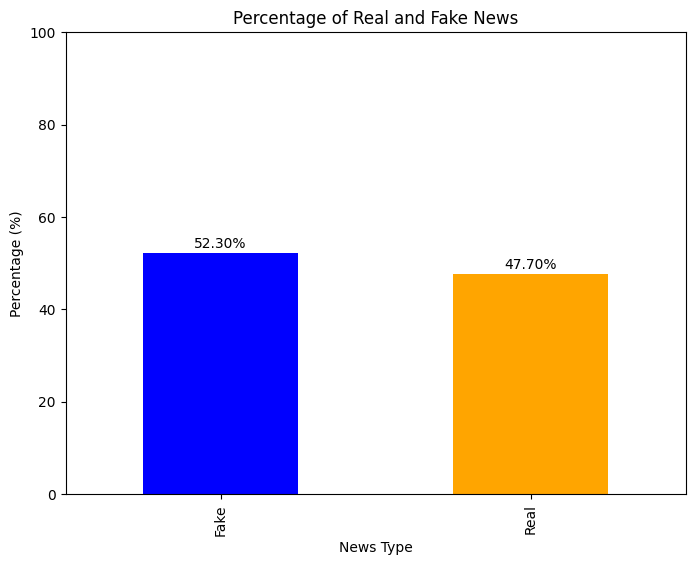

In [8]:
target_percentage_map = df["target"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
target_percentage_map.plot(kind="bar", color=['blue', 'orange'])
plt.title("Percentage of Real and Fake News")
plt.xlabel("News Type")
plt.ylabel("Percentage (%)")
for index, value in enumerate(target_percentage_map):
    plt.text(index, value + 1, f"{value:.2f}%", ha='center')

plt.ylim(0, 100)
plt.show()

# Preparing data

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

df["combined_text"] = df["title"] + " " + df["text"]
df["target"] = df["target"].map(targets)

X_train, X_test, y_train, y_test = train_test_split(
    df["combined_text"],
    df["target"],
    test_size=0.2,
    random_state=42,
    stratify=df["target"]
)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

y_train = y_train.to_numpy()
y_test  = y_test.to_numpy()

print("Training feature matrix shape:", X_train.shape)
print("Testing feature matrix shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training feature matrix shape: (35918, 5000)
Testing feature matrix shape: (8980, 5000)
Training labels shape: (35918,)
Testing labels shape: (8980,)


# Grid Search & Cross validation

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

models = {
    "MLPClassifier": MLPClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "MultinomialNB": MultinomialNB()
}

param_grids = {
    "MLPClassifier": {
        "hidden_layer_sizes": [
            (50, 25),
            (100, 50),
            (150, 75)
        ],
        "learning_rate_init": [0.01, 0.1, 0.25],
        "activation": ["relu"],
        "alpha": [0.0001],
        "max_iter": [120]
    },
    "RandomForestClassifier": {
        "n_estimators": [100, 200],
        "max_depth": [None, 20],
        "min_samples_leaf": [1, 2]
    },
    "MultinomialNB": {
        "alpha": [0.1, 1.0]
    }
}

best_models = {}

for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")

Performing Grid Search for MLPClassifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 75), 'learning_rate_init': 0.01, 'max_iter': 120}
Performing Grid Search for RandomForestClassifier...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Performing Grid Search for MultinomialNB...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for MultinomialNB: {'alpha': 0.1}


# Traning Model

Accuracy for MLPClassifier: 0.9910913140311804
Classification Report for MLPClassifier:
               precision    recall  f1-score   support

        Real     0.9888    0.9925    0.9907      4284
        Fake     0.9932    0.9898    0.9915      4696

    accuracy                         0.9911      8980
   macro avg     0.9910    0.9912    0.9911      8980
weighted avg     0.9911    0.9911    0.9911      8980



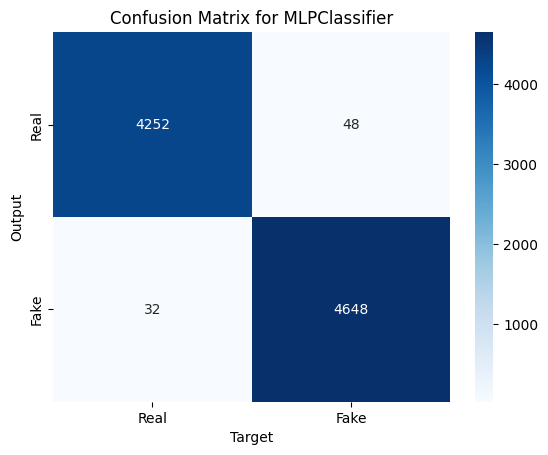

Accuracy for RandomForestClassifier: 0.9972160356347439
Classification Report for RandomForestClassifier:
               precision    recall  f1-score   support

        Real     0.9979    0.9963    0.9971      4284
        Fake     0.9966    0.9981    0.9973      4696

    accuracy                         0.9972      8980
   macro avg     0.9972    0.9972    0.9972      8980
weighted avg     0.9972    0.9972    0.9972      8980



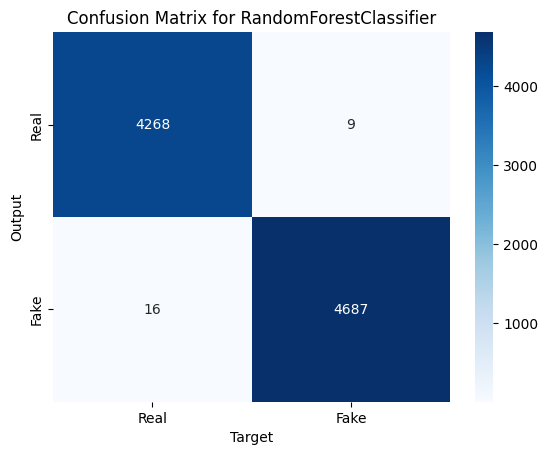

Accuracy for MultinomialNB: 0.932293986636971
Classification Report for MultinomialNB:
               precision    recall  f1-score   support

        Real     0.9429    0.9134    0.9279      4284
        Fake     0.9232    0.9495    0.9362      4696

    accuracy                         0.9323      8980
   macro avg     0.9330    0.9315    0.9320      8980
weighted avg     0.9326    0.9323    0.9322      8980



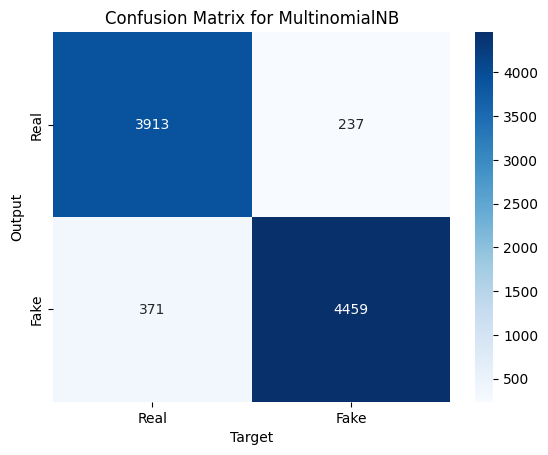

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


class_names = [REAL, FAKE]

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Accuracy for {model_name}:", accuracy_score(y_test, y_pred))
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred, digits=4, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    cm_t = cm.T

    sns.heatmap(cm_t, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Target")
    plt.ylabel("Output")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()